In [ ]:
# import libraries
!pip install datasets
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# downloading NLTK data files
nltk.download('punkt')
nltk.download('stopwords')


Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# load the dataset and meta_data
mbr_data = load_dataset('recmeapp/mobilerec', data_dir='interactions')
mbr_meta = load_dataset('recmeapp/mobilerec', data_dir='app_meta')

In [ ]:
# Save the dataset directly to Google Drive as a CSV file
mbr_data['train'].to_csv('/content/drive/MyDrive/mbr_data.csv')

Creating CSV from Arrow format:   0%|          | 0/19298 [00:00<?, ?ba/s]

4416651630

In [ ]:
mobilerec_df = pd.read_csv('/content/drive/MyDrive/mbr_data.csv')

In [ ]:
print(f'There are {len(mobilerec_df)} interactions in mobilerec dataset.')
print(f'There are {len(mobilerec_df["app_package"].unique())} unique apps in mobilerec dataset.')
print(f'There are {len(mobilerec_df["uid"].unique())} unique users in mobilerec dataset.')
print(f'There are {len(mobilerec_df["app_category"].unique())} unique categories in mobilerec dataset.')

There are 19297019 interactions in mobilerec dataset.
There are 10173 unique apps in mobilerec dataset.
There are 700111 unique users in mobilerec dataset.
There are 48 unique categories in mobilerec dataset.


In [ ]:
# Check the column names of the dataframe
print(mobilerec_df.columns)

Index(['app_package', 'review', 'rating', 'votes', 'date', 'uid',
       'formated_date', 'unix_timestamp', 'app_category'],
      dtype='object')


In [ ]:
# Get the total number of rows
total_rows = len(mobilerec_df)

# Calculate the number of rows in each split
rows_per_split = total_rows // 20

# Take the first split (you can adjust this to choose a different split, e.g., second split, third split, etc.)
# split_1 = mobilerec_df.iloc[:rows_per_split]

# make an explicit copy of main dataframe
split_1 = mobilerec_df.iloc[:rows_per_split].copy()

In [ ]:
# Calculate the memory usage of split_1 in bytes
memory_usage_bytes = split_1.memory_usage(deep=True).sum()

# Convert the memory usage to megabytes (MB)
memory_usage_mb = memory_usage_bytes / (1024 * 1024)

# Print the memory usage in MB
print(f"The size of split_1 is approximately {memory_usage_mb:.2f} MB")

The size of split_1 is approximately 547.66 MB


In [ ]:
# Pre-process review text: clean and tokenize
stop_words = set(stopwords.words('english'))

def preprocess_review(text):
    # Check if the input is a string (in case of NaN or non-string values)
    if isinstance(text, str):
        # Lowercase the text
        text = text.lower()

        # Remove punctuation and tokenize
        tokens = word_tokenize(re.sub(r'[^\w\s]', '', text))

        # Remove stopwords
        filtered_tokens = [word for word in tokens if word not in stop_words]

        return filtered_tokens
    else:
        # Return an empty list for non-string inputs
        return []

# Apply the preprocessing to the 'review' column of the split dataset
split_1['processed_reviews'] = split_1['review'].apply(preprocess_review)

<ipython-input-8-c46ed1f66bf4>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1['processed_reviews'] = split_1['review'].apply(preprocess_review)


In [ ]:
# Display a sample of the processed reviews
split_1[['review', 'processed_reviews']].head()

,review,processed_reviews
0,It's really a fun game,"[really, fun, game]"
1,uninstalling. it was ok but felt like it was c...,"[uninstalling, ok, felt, like, controlling, ho..."
2,Love this game,"[love, game]"
3,Doesn't update play time. Just downloaded it 3...,"[doesnt, update, play, time, downloaded, 3, da..."
4,app crashes every time I try to log in. what g...,"[app, crashes, every, time, try, log, gives]"


In [ ]:
# Define a set of specific features to track
feature_list = ["battery life", "UI design", "graphics", "performance", "camera", "user experience", "features"]

# Create a function to count feature mentions in the processed reviews
def count_feature_mentions(tokens, feature_list):
    feature_count = {}
    for feature in feature_list:
        feature_count[feature] = sum(1 for word in tokens if word in feature.split())
    return feature_count

# Apply the counting function to each review in the split_1 dataset
split_1['feature_mentions'] = split_1['processed_reviews'].apply(lambda x: count_feature_mentions(x, feature_list))

# Convert the dictionary of feature counts into separate columns
features_df = pd.DataFrame(list(split_1['feature_mentions'])).fillna(0)

# Add these feature columns back to the original dataframe (split_1)
split_1 = pd.concat([split_1, features_df], axis=1)


<ipython-input-10-a8da36eebf72>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1['feature_mentions'] = split_1['processed_reviews'].apply(lambda x: count_feature_mentions(x, feature_list))


In [ ]:
# Compute correlation between feature mentions and success metrics for split_1
correlations = {}
for feature in feature_list:
    correlation_votes = split_1[feature].corr(split_1['votes'])
    correlation_ratings = split_1[feature].corr(split_1['rating'])

    correlations[feature] = {'votes': correlation_votes, 'rating': correlation_ratings}

# Convert correlations into a DataFrame for better readability
correlation_df = pd.DataFrame(correlations).T
print(correlation_df)

                    votes    rating
battery life     0.009326  0.005447
UI design        0.009028  0.005266
graphics         0.021069  0.049816
performance      0.007874 -0.004340
camera           0.007938 -0.015341
user experience  0.022138 -0.004067
features         0.023496  0.005743


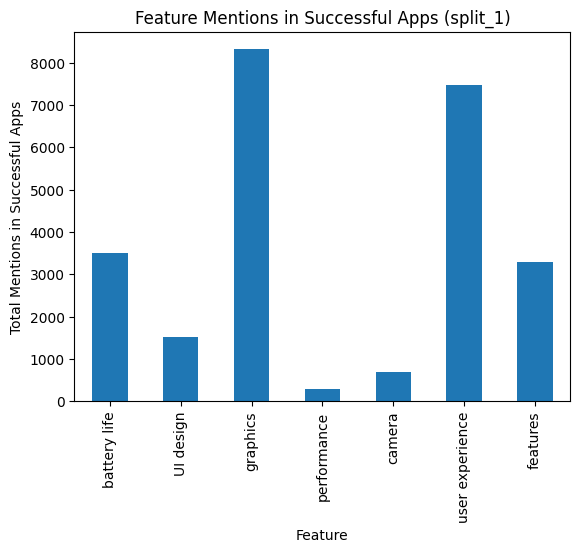

In [ ]:
# Define success threshold
success_threshold = 4.5  # Assuming rating is on a scale of 1-5

# Aggregate the counts of feature mentions for successful apps in split_1
successful_apps_df = split_1[split_1['rating'] >= success_threshold]
feature_totals = successful_apps_df[feature_list].sum()

# Plot the frequencies of feature mentions in successful apps
feature_totals.plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Total Mentions in Successful Apps')
plt.title('Feature Mentions in Successful Apps (split_1)')
plt.show()

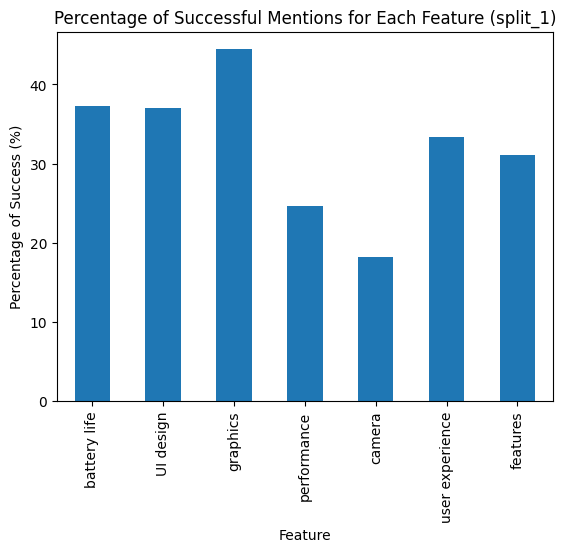

Percentage of Successful Mentions for Each Feature (sorted):
graphics           44.429595
battery life       37.296780
UI design          37.024390
user experience    33.312542
features           31.130468
performance        24.663300
camera             18.219677
dtype: float64

Absolute Counts of Feature Mentions in Successful Apps (split_1, sorted):
graphics           8311
user experience    7477
battery life       3510
features           3288
UI design          1518
camera              700
performance         293
dtype: int64


In [ ]:
# Aggregate the counts of feature mentions for successful apps in split_1
successful_apps_df = split_1[split_1['rating'] >= success_threshold]
feature_totals_successful = successful_apps_df[feature_list].sum()

# Aggregate the total counts of feature mentions in split_1
feature_totals_overall = split_1[feature_list].sum()

# Calculate the percentage of successful mentions for each feature
percentage_successful = (feature_totals_successful / feature_totals_overall) * 100

# Plot the percentages of success for each feature
percentage_successful.plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Percentage of Success (%)')
plt.title('Percentage of Successful Mentions for Each Feature (split_1)')
plt.show()
# Sort and print the percentage of successful mentions in descending order
percentage_successful_sorted = percentage_successful.sort_values(ascending=False)
print("Percentage of Successful Mentions for Each Feature (sorted):")
print(percentage_successful_sorted)
print()

# Sort and print the absolute counts of feature mentions in successful apps in descending order
feature_totals_successful_sorted = feature_totals_successful.sort_values(ascending=False)
print("Absolute Counts of Feature Mentions in Successful Apps (split_1, sorted):")
print(feature_totals_successful_sorted)



In [ ]:
# TASK-7

# Define a broader set of UX-related terms to track
ux_related_terms = [
    "user-friendly", "intuitive design", "easy to use", "responsive",
    "smooth experience", "good interface", "easy navigation", "UI",
    "UX", "interface", "layout", "design", "user experience",
    "user interface", "simple", "straightforward", "convenient"
]

# Function to count mentions of UX-related terms in each review
def count_ux_mentions(text, ux_related_terms):
    ux_count = 0
    if isinstance(text, str):
        # Convert to lowercase for case-insensitive matching
        text = text.lower()
        for term in ux_related_terms:
            # Use substring matching for more flexible term detection
            if term.lower() in text:
                ux_count += 1
    return ux_count

# Apply the updated counting function to each review in the split_1 dataset
split_1['ux_mentions'] = split_1['review'].apply(lambda x: count_ux_mentions(x, ux_related_terms))

# Display a sample of the UX mentions
print(split_1[['review', 'ux_mentions']].head())


                                              review  ux_mentions
0                             It's really a fun game            0
1  uninstalling. it was ok but felt like it was c...            0
2                                     Love this game            0
3  Doesn't update play time. Just downloaded it 3...            0
4  app crashes every time I try to log in. what g...            0


In [ ]:
# Calculate the correlation between UX mentions and the app's overall rating
correlation_ux_rating = split_1['ux_mentions'].corr(split_1['rating'])

# Print the correlation
print(f"Correlation between UX mentions and app ratings: {correlation_ux_rating:.4f}")

Correlation between UX mentions and app ratings: 0.0422


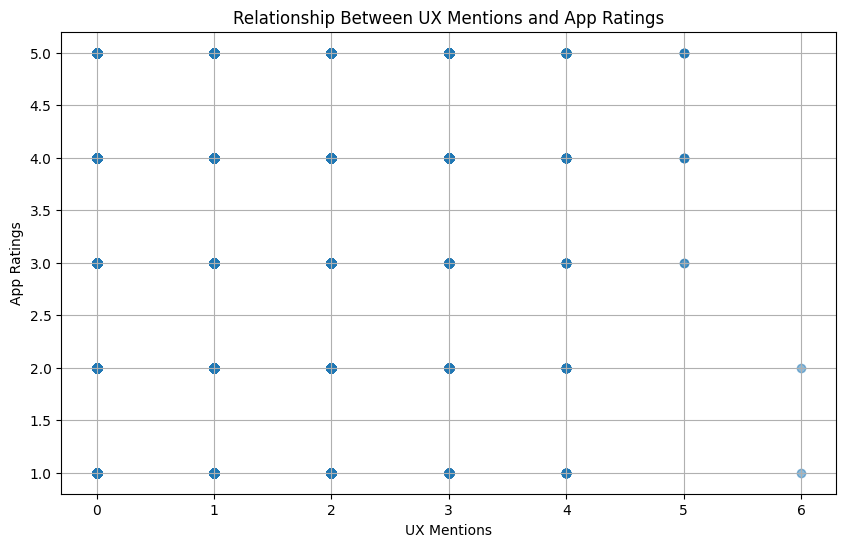

In [ ]:
# Scatter plot to visualize the relationship between UX mentions and app ratings
plt.figure(figsize=(10, 6))
plt.scatter(split_1['ux_mentions'], split_1['rating'], alpha=0.5)
plt.title('Relationship Between UX Mentions and App Ratings')
plt.xlabel('UX Mentions')
plt.ylabel('App Ratings')
plt.grid(True)
plt.show()

In [ ]:
# Function to count mentions of each specific UX term in each review
def count_specific_ux_mentions(text, term):
    if isinstance(text, str):
        text = text.lower()
        return text.count(term.lower())  # Count occurrences of the term
    return 0

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


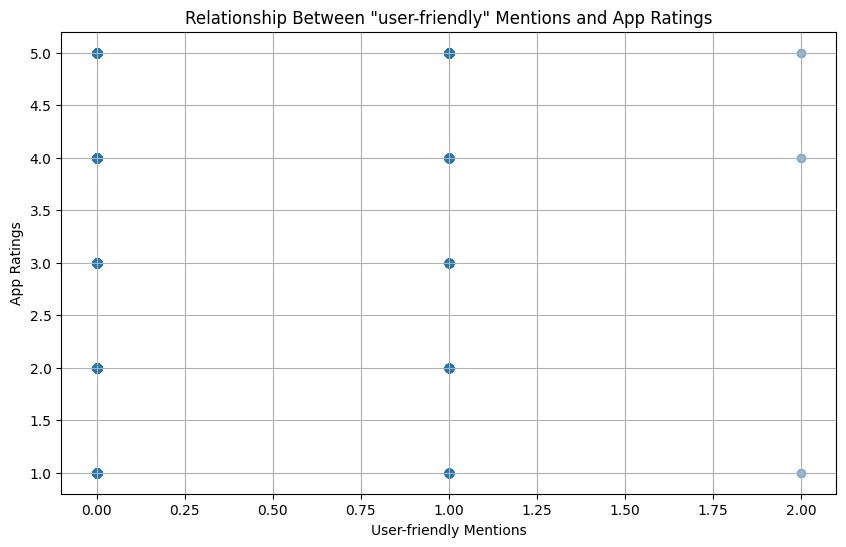

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


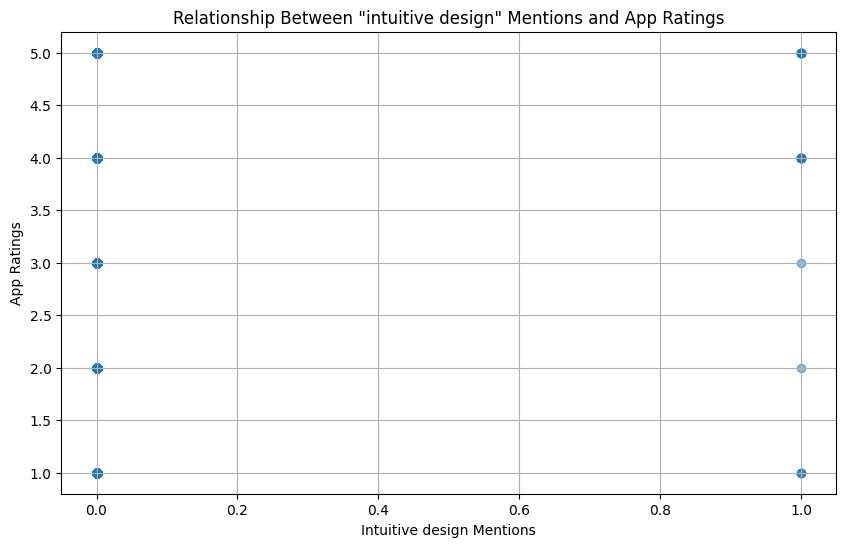

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


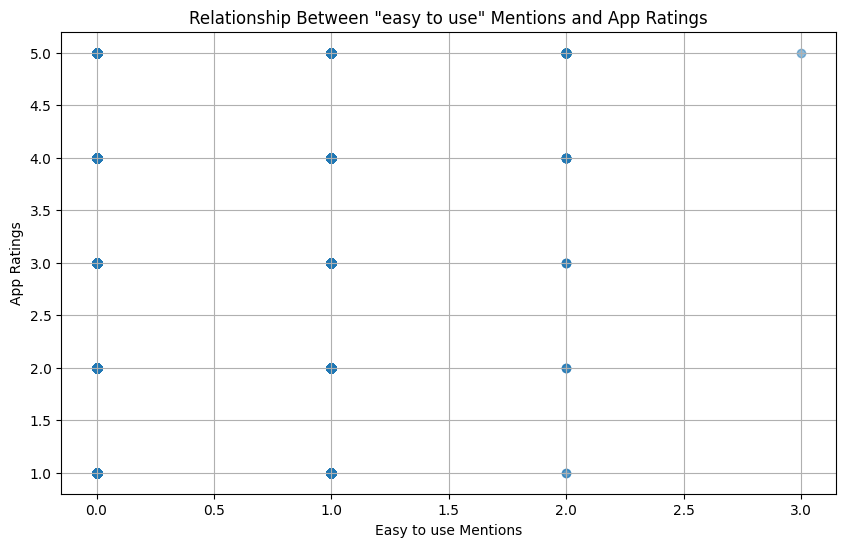

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


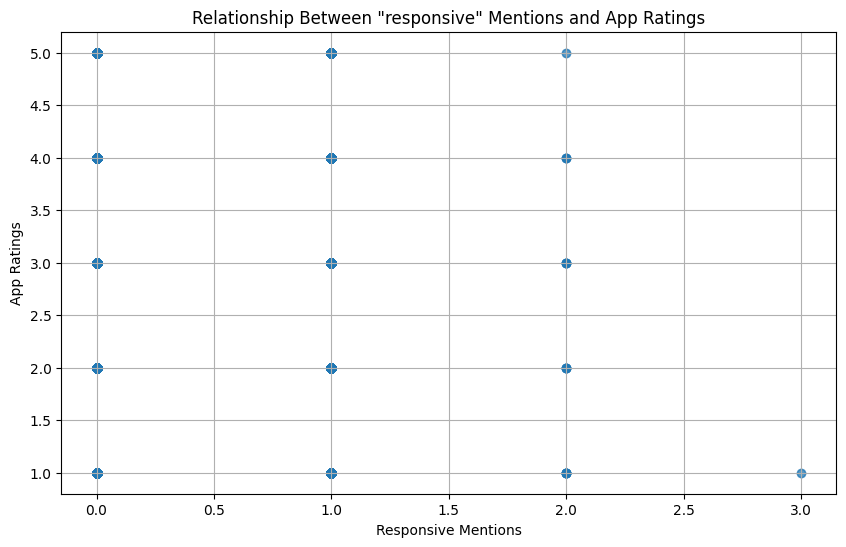

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


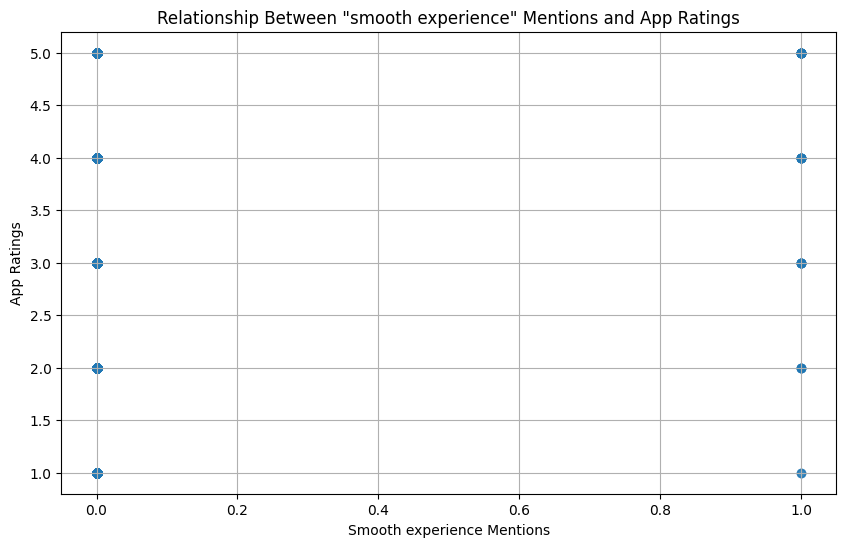

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


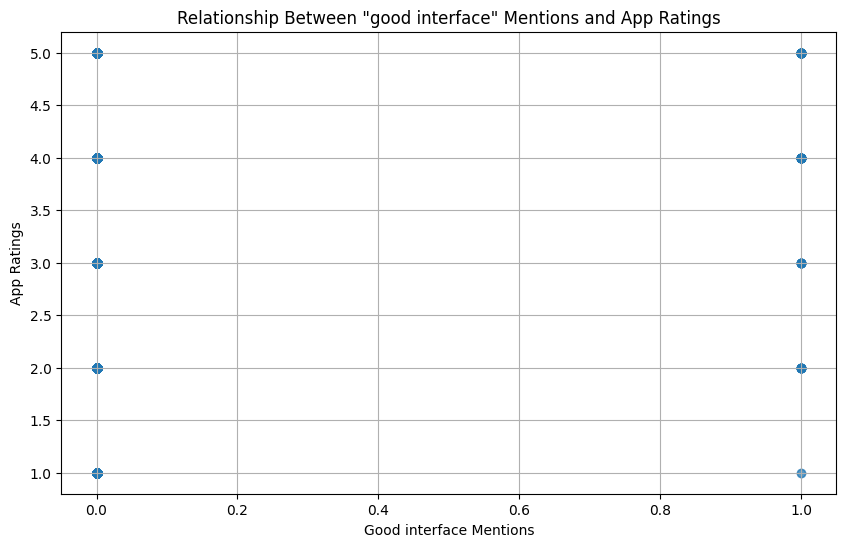

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


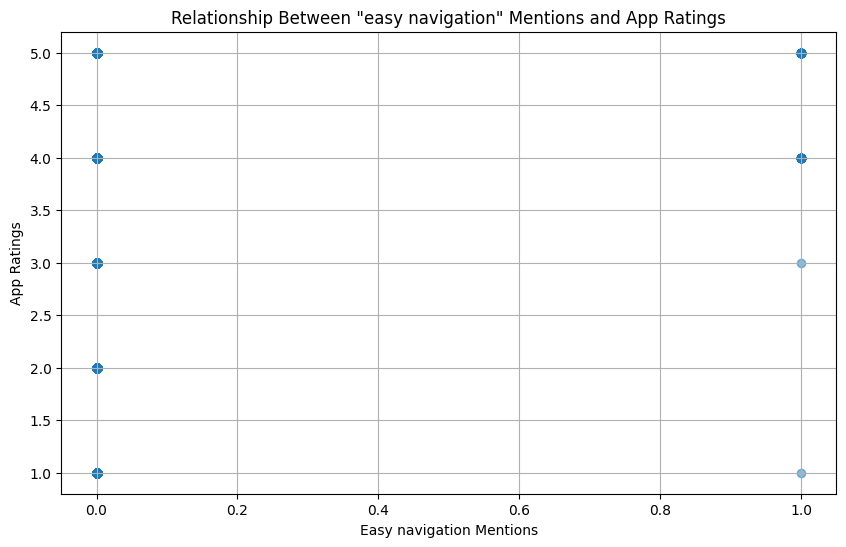

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


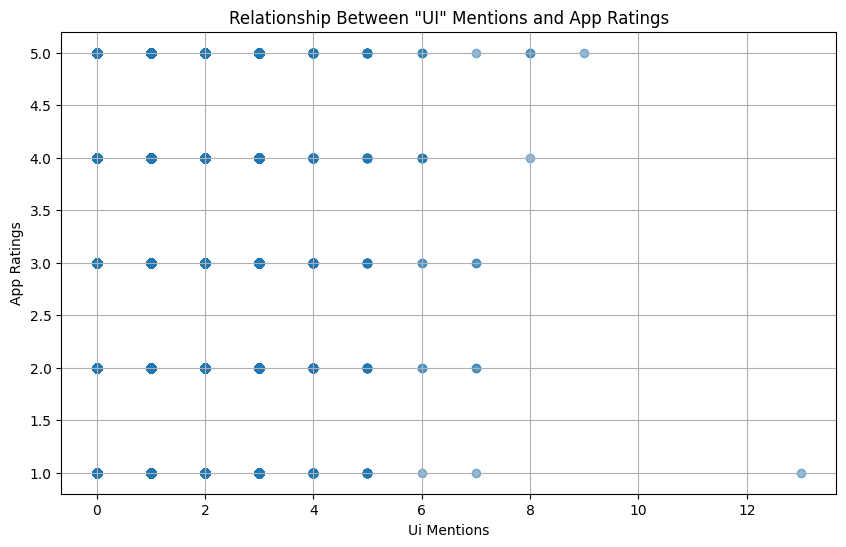

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


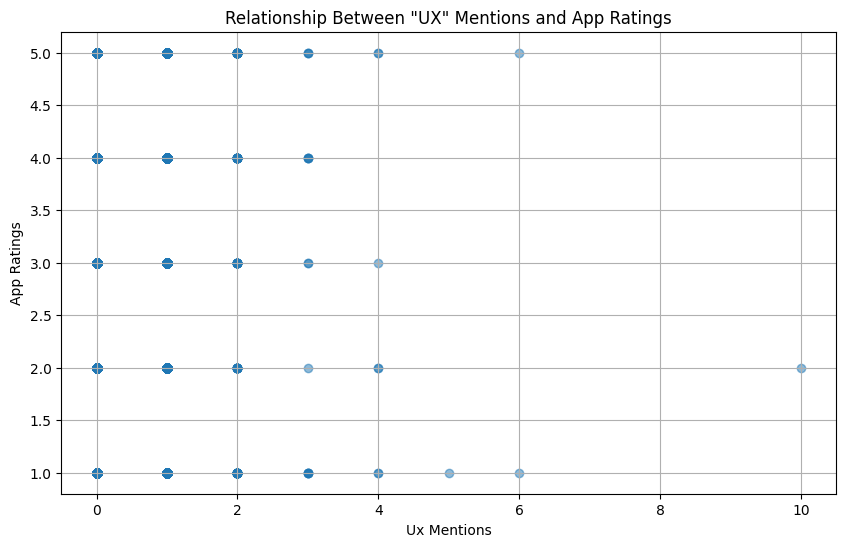

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


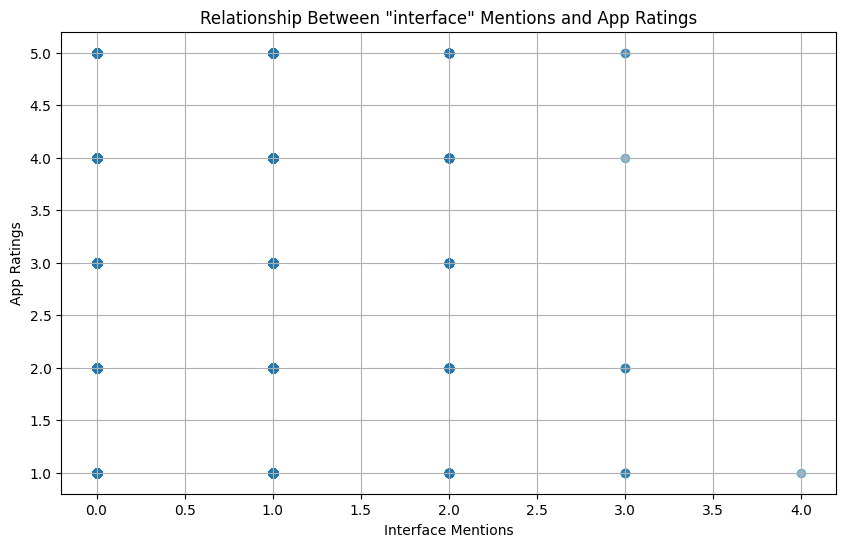

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


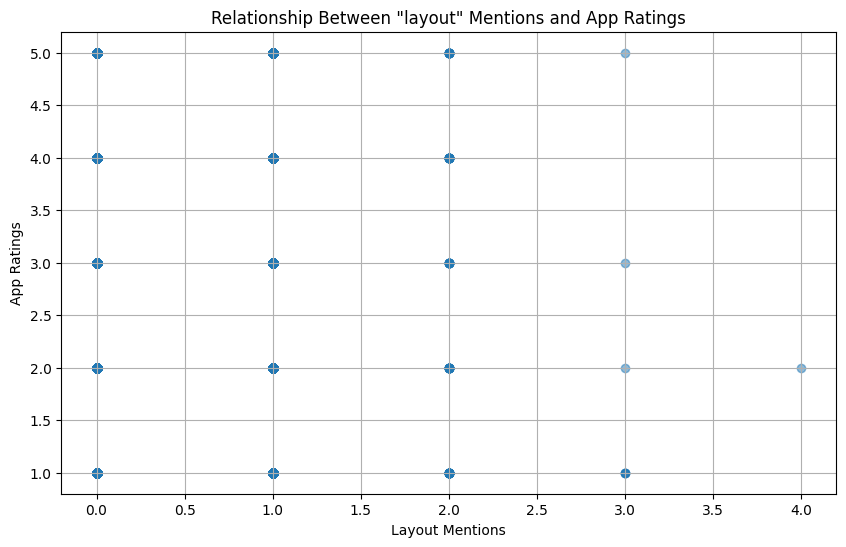

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


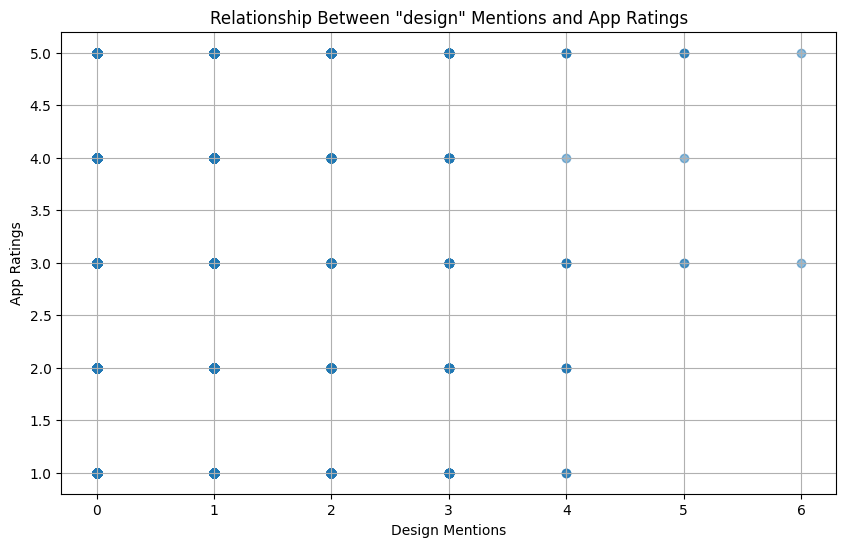

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


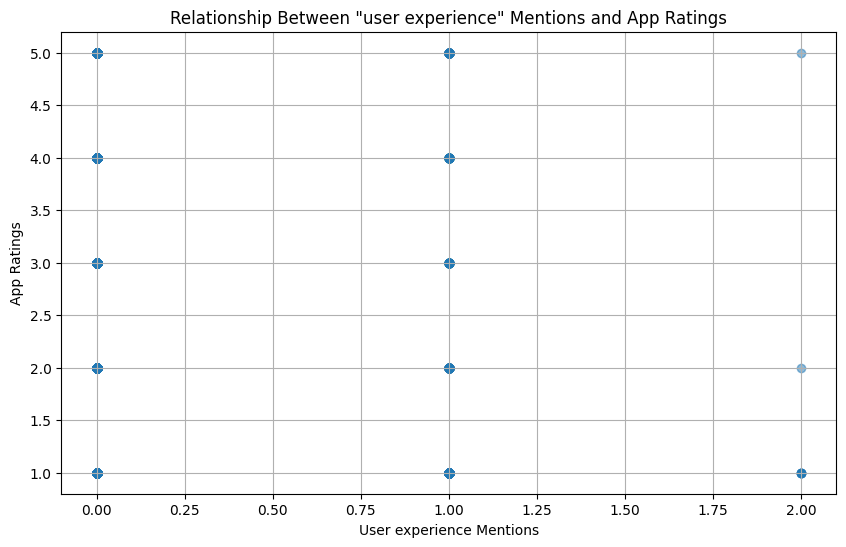

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


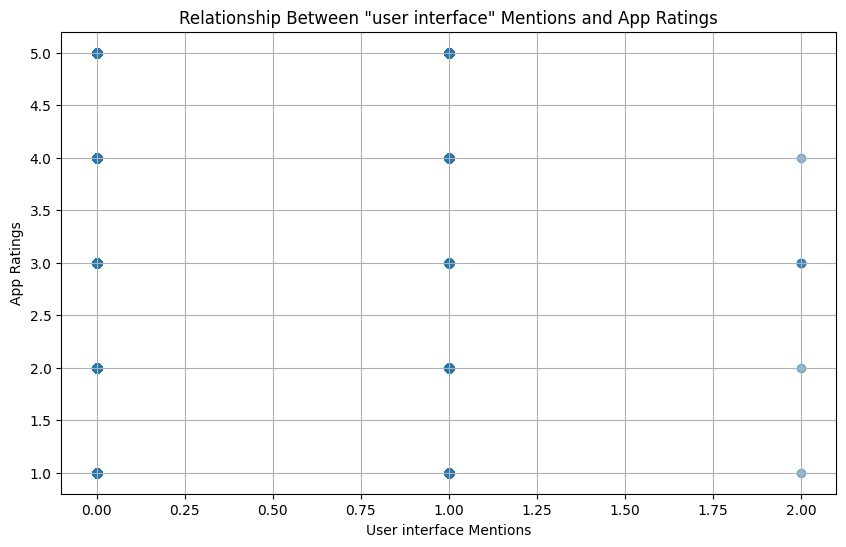

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


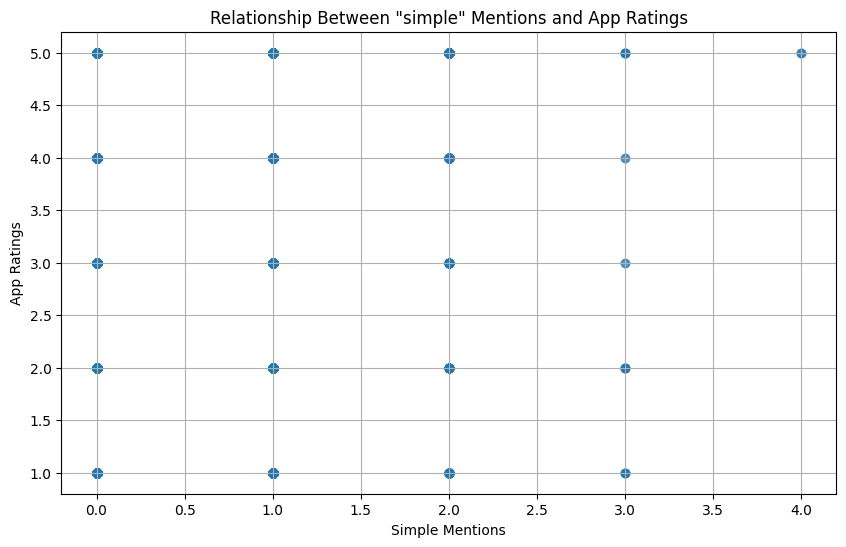

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


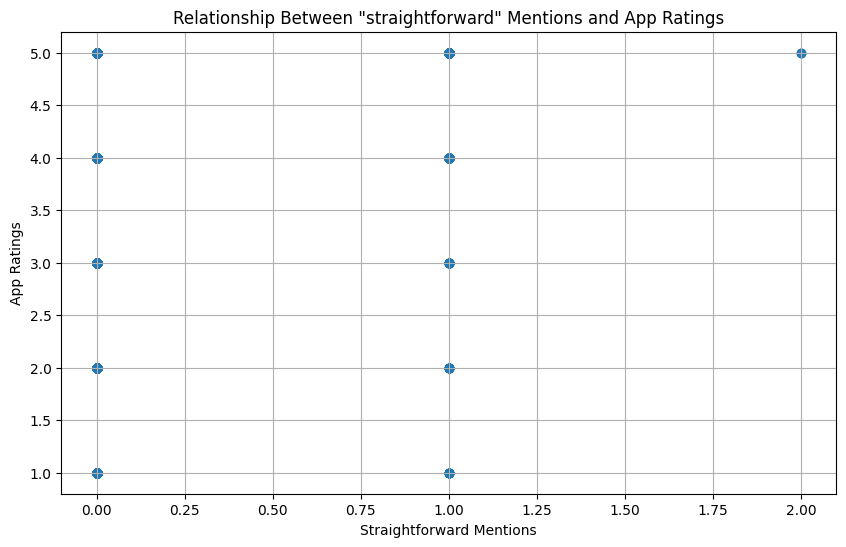

<ipython-input-27-867cb774f72d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))


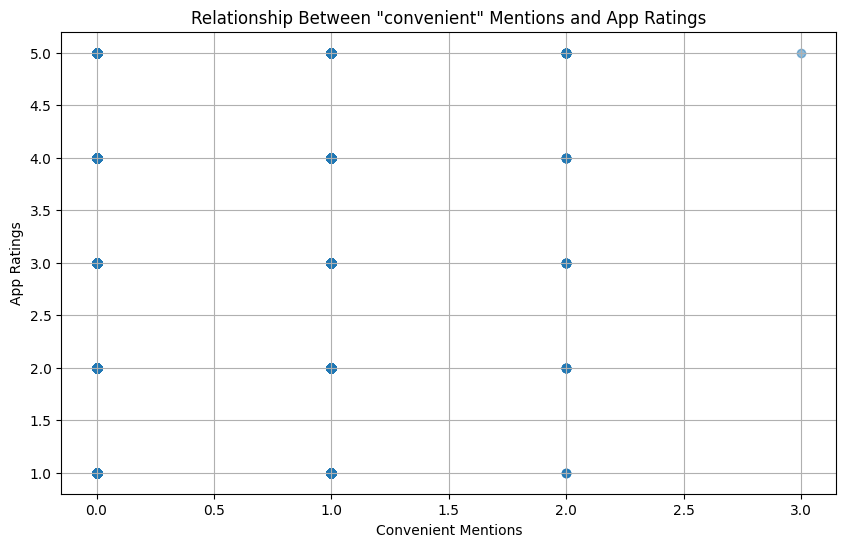

In [ ]:
# Iterate over each term in ux_related_terms and create a scatter plot for each
for term in ux_related_terms:
    # Create a new column in split_1 for each UX-related term with counts of mentions
    split_1[f'{term}_mentions'] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term))

    # Scatter plot to visualize the relationship between specific UX term mentions and app ratings
    plt.figure(figsize=(10, 6))
    plt.scatter(split_1[f'no_of_{term}_mentions'], split_1['rating'], alpha=0.5)
    plt.title(f'Relationship Between "{term}" Mentions and App Ratings')
    plt.xlabel(f'{term.capitalize()} Mentions')
    plt.ylabel('App Ratings')
    plt.grid(True)
    plt.show()

In [ ]:
# Initialize a dictionary to store total mentions for each term
total_mentions = {term: 0 for term in ux_related_terms}

# Count the number of mentions for each UX-related term in all reviews
for term in ux_related_terms:
    # Count the mentions for each term and add to the total_mentions dictionary
    total_mentions[term] = split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term)).sum()

# Print the total number of mentions for each UX-related term
print("Total Mentions of Each UX-Related Term Across All Reviews:")
for term, count in total_mentions.items():
    print(f"{term}: {count}")

# Print the corresponding app ratings for the reviews that contain these mentions
print("\nApp Ratings Corresponding to Reviews that Contain UX-Related Terms:")

# Iterate over each term to find reviews where the term is mentioned and print the app ratings
for term in ux_related_terms:
    print(f"\nApp Ratings for Reviews Containing the Term '{term}':")
    ratings_for_term = split_1.loc[split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term)) > 0, 'rating']
    print(ratings_for_term.to_list())

Total Mentions of Each UX-Related Term Across All Reviews:
user-friendly: 399
intuitive design: 20
easy to use: 13429
responsive: 1466
smooth experience: 50
good interface: 89
easy navigation: 52
UI: 59909
UX: 1622
interface: 4236
layout: 1838
design: 8218
user experience: 501
user interface: 652
simple: 11267
straightforward: 444
convenient: 3872

App Ratings Corresponding to Reviews that Contain UX-Related Terms:

App Ratings for Reviews Containing the Term 'user-friendly':
[5, 5, 5, 5, 5, 5, 2, 1, 1, 5, 5, 4, 2, 5, 3, 2, 4, 1, 4, 4, 1, 5, 3, 5, 5, 5, 5, 2, 1, 4, 5, 4, 1, 1, 1, 1, 1, 5, 5, 5, 1, 4, 1, 5, 4, 2, 5, 2, 2, 1, 5, 4, 1, 3, 5, 5, 5, 4, 5, 2, 5, 2, 4, 5, 5, 3, 5, 3, 5, 5, 1, 4, 5, 4, 5, 4, 3, 5, 5, 3, 2, 1, 5, 3, 5, 2, 5, 4, 4, 5, 5, 5, 3, 2, 5, 4, 5, 3, 5, 4, 5, 1, 2, 4, 5, 4, 1, 5, 5, 3, 4, 2, 5, 3, 5, 3, 4, 5, 4, 5, 3, 2, 2, 1, 5, 3, 1, 3, 5, 5, 4, 4, 4, 5, 5, 2, 5, 4, 2, 5, 1, 3, 5, 5, 4, 3, 5, 3, 4, 1, 5, 5, 3, 5, 1, 2, 4, 4, 1, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 4, 1,

In [ ]:
# Function to calculate the percentage of ratings corresponding to a UX-related term
def calculate_rating_percentages(term):
    # Get all the ratings for reviews that mention the specific UX term
    ratings_for_term = split_1.loc[split_1['review'].apply(lambda x: count_specific_ux_mentions(x, term)) > 0, 'rating']

    # Count the occurrences of each rating (1 through 5)
    rating_counts = ratings_for_term.value_counts().sort_index()

    # Calculate the percentage for each rating
    rating_percentages = (rating_counts / rating_counts.sum()) * 100

    return rating_percentages

# Iterate over each UX-related term and print the percentage of ratings
for term in ux_related_terms:
    print(f"\nPercentage of Ratings for Reviews Containing the Term '{term}':")
    rating_percentages = calculate_rating_percentages(term)
    print(rating_percentages)



Percentage of Ratings for Reviews Containing the Term 'user-friendly':
rating
1    13.383838
2     9.595960
3    10.606061
4    21.464646
5    44.949495
Name: count, dtype: float64

Percentage of Ratings for Reviews Containing the Term 'intuitive design':
rating
1    15.0
2     5.0
3     5.0
4    35.0
5    40.0
Name: count, dtype: float64

Percentage of Ratings for Reviews Containing the Term 'easy to use':
rating
1     1.610608
2     2.359727
3     5.153944
4    24.616076
5    66.259645
Name: count, dtype: float64

Percentage of Ratings for Reviews Containing the Term 'responsive':
rating
1    26.624738
2    16.282320
3    16.142558
4    14.954577
5    25.995807
Name: count, dtype: float64

Percentage of Ratings for Reviews Containing the Term 'smooth experience':
rating
1     6.0
2    12.0
3    20.0
4    24.0
5    38.0
Name: count, dtype: float64

Percentage of Ratings for Reviews Containing the Term 'good interface':
rating
1     2.247191
2    14.606742
3    11.235955
4    26.96629

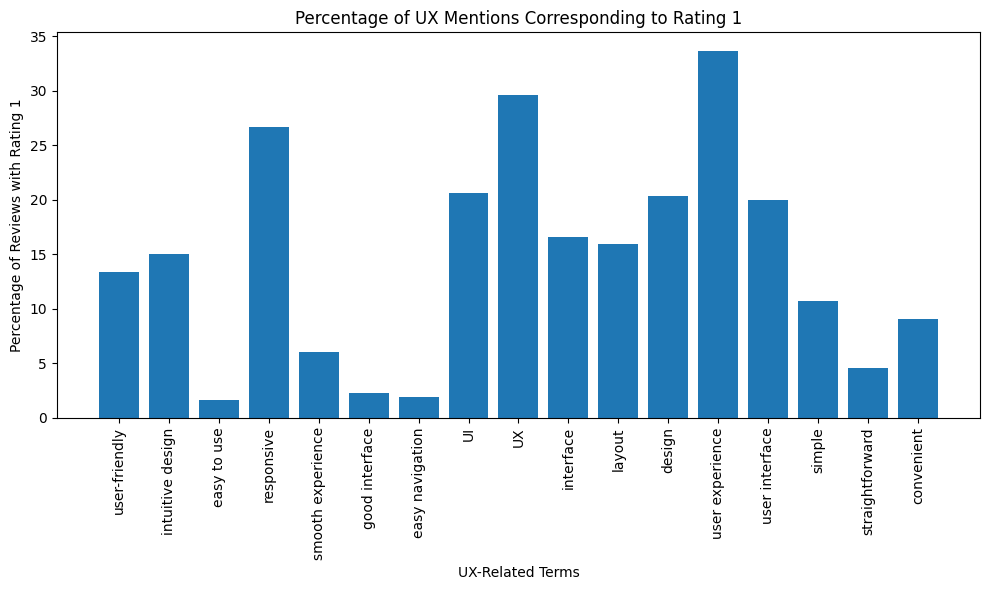

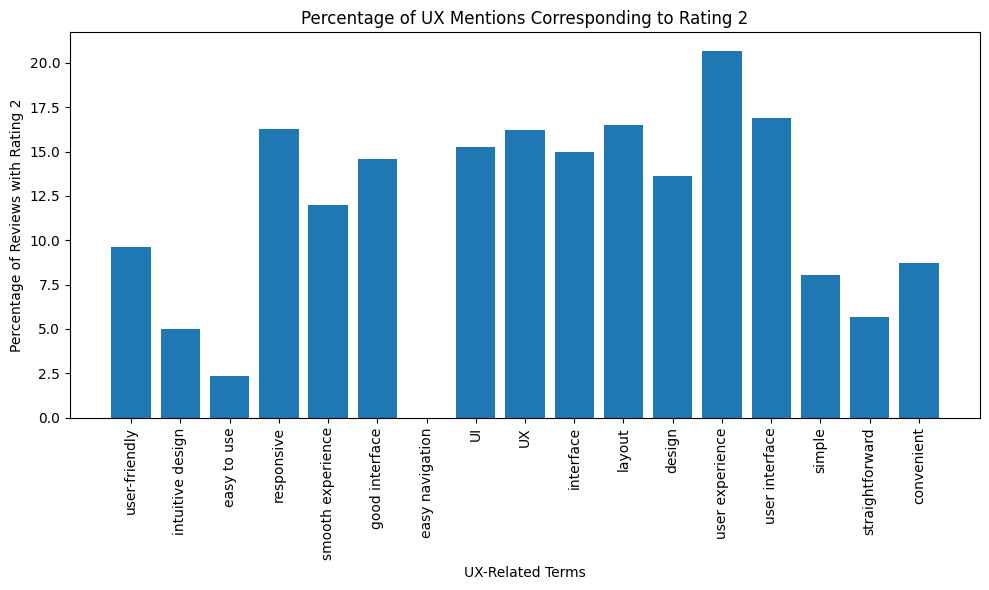

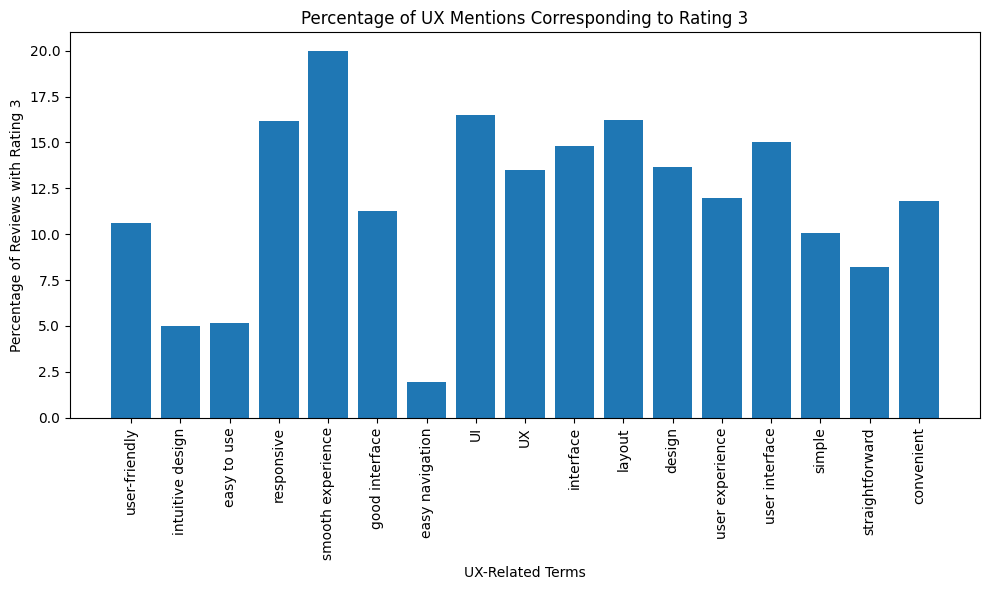

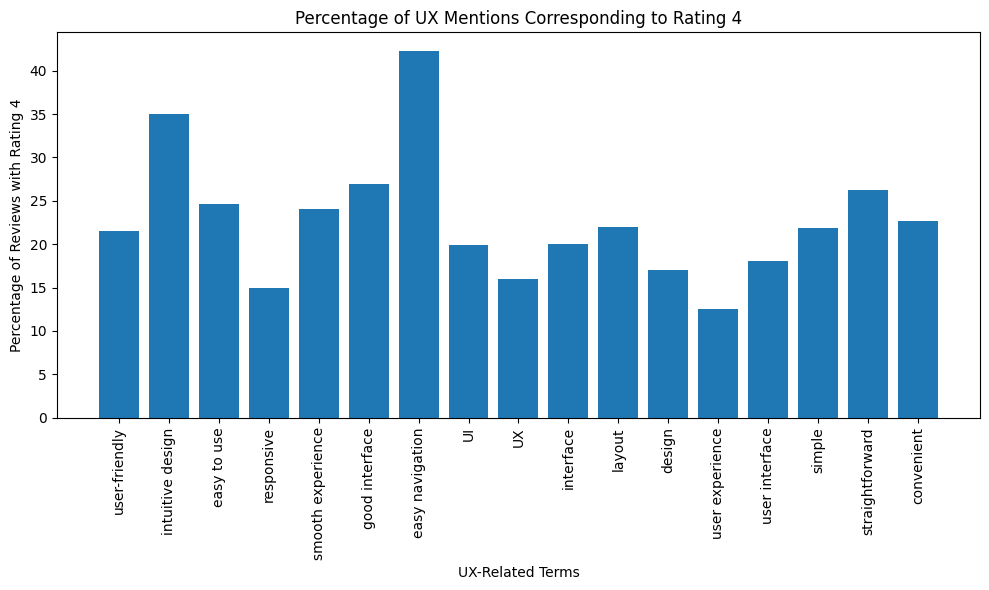

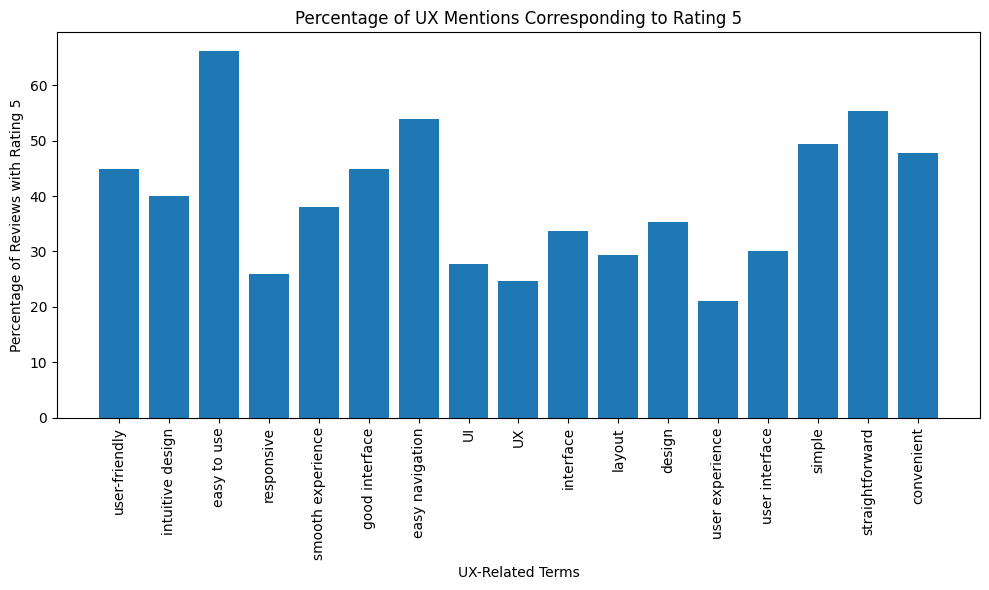

In [ ]:
# Prepare data for each rating from 1 to 5
rating_percentages_by_term = {rating: [] for rating in range(1, 6)}

# Populate the percentage data for each rating for all terms
for term in ux_related_terms:
    rating_percentages = calculate_rating_percentages(term)
    for rating in range(1, 6):
        # Append the percentage for the current term and rating
        rating_percentages_by_term[rating].append(rating_percentages.get(rating, 0))  # Default to 0 if rating not found

# Plot a graph for each rating from 1 to 5
for rating in range(1, 6):
    plt.figure(figsize=(10, 6))
    plt.bar(ux_related_terms, rating_percentages_by_term[rating])
    plt.xlabel('UX-Related Terms')
    plt.ylabel(f'Percentage of Reviews with Rating {rating}')
    plt.title(f'Percentage of UX Mentions Corresponding to Rating {rating}')
    plt.xticks(rotation=90)  # Rotate x labels for better readability
    plt.tight_layout()
    plt.show()


In [ ]:
++